In [250]:
import os
import lime
import pickle
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.utils import Sequence
from keras.models import Sequential
from keras.models import load_model
from keras.applications import MobileNet
from keras.layers import Dense, Flatten, Dropout
from sklearn.metrics import confusion_matrix, classification_report

In [260]:
batch_size = 32
dataset_code = 'A'
model_name = 'MobileNet'
data_saved_dir = r'E:\Post-Flood-Disaster-Management\Classification\pickle_data'
model_saved_dir = r'E:\Post-Flood-Disaster-Management\Classification\models'
test_data_path = f'{data_saved_dir}\\floodnet_testing.pkl'

In [261]:
def load_pickle(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data

test_images, test_labels = load_pickle(test_data_path)
print(f'Testing images: {test_images.shape}')

Testing images: (62, 256, 256, 3)


In [262]:
class CustomDataGenerator(Sequence):
    def __init__(self, images, labels, batch_size):
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.images))

    def __len__(self):
        return int(np.ceil(len(self.images) / self.batch_size))

    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        batch_images = self.images[start:end]
        batch_labels = self.labels[start:end]
        return batch_images, batch_labels

test_data_generator = CustomDataGenerator(test_images, test_labels, batch_size)

['A_MobileNet-weights-improvement-06-0.97.hdf5']
Best model loaded ...
2/2 [==============================] - 1s 351ms/step


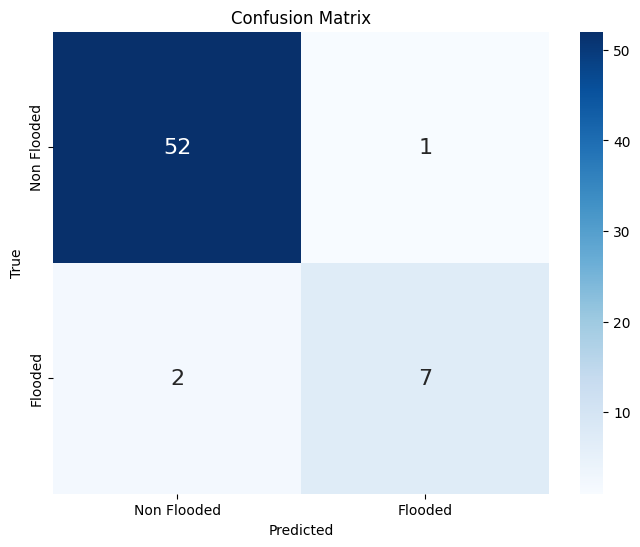

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97        53
           1       0.88      0.78      0.82         9

    accuracy                           0.95        62
   macro avg       0.92      0.88      0.90        62
weighted avg       0.95      0.95      0.95        62



In [263]:
model_dir = f'{model_saved_dir}\{dataset_code}_{model_name}'

models = sorted(os.listdir(model_dir))

for file in models[:-1]:
    os.remove(f'{model_dir}\{file}')

print(os.listdir(model_dir))
best_model = load_model(f'{model_dir}\{models[-1]}')
print('Best model loaded ...')

predictions = best_model.predict(test_data_generator)

predicted_labels = (predictions > 0.5).astype(int)

conf_matrix = confusion_matrix(test_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non Flooded', 'Flooded'], yticklabels=['Non Flooded', 'Flooded'], annot_kws={'size':16})
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:")
print(classification_report(test_labels, predicted_labels))

In [264]:
import lime
from lime import lime_image
from lime import submodular_pick
from skimage.segmentation import mark_boundaries


X_test_images = test_data_generator[0][0]
X_test_labels = test_data_generator[0][1]

In [293]:
def apply_lime(image, label):

    explainer = lime_image.LimeImageExplainer()
    exp = explainer.explain_instance(image, 
                                    best_model.predict, 
                                    top_labels=1, 
                                    hide_color=0, 
                                    num_samples=1000)
    
    temp, mask = exp.get_image_and_mask(exp.top_labels[0], positive_only=True, negative_only=False, num_features=5, hide_rest=True)

    img = np.expand_dims(image, axis=0)
    predicted = "Non-Flooded"
    if (best_model.predict(img)[0][0] > 0.5):
        print(f'Predicted: Flooded with {round(best_model.predict(img)[0][0] * 100, 2)}% confidence')
        predicted = "Flooded"
    else:
        print(f'Predicted: Non-Flooded with {round((1 - best_model.predict(img)[0][0]) * 100, 2)}% confidence')

        
    plt.figure(figsize=(14, 8))
    plt.subplot(1, 2, 1)  
    plt.imshow(image)
    plt.title(f'Original Image \n Ground Truth:{"Flooded" if label == 1 else "Non-Flooded"}')

    plt.subplot(1, 2, 2)
    dict_heatmap = dict(exp.local_exp[exp.top_labels[0]])
    heatmap = np.vectorize(dict_heatmap.get)(exp.segments) 
    plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
    plt.colorbar()
    plt.title(f'Heatmap \n Predicted: {predicted}')

    plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step
Predicted: Flooded with 96.85% confidence


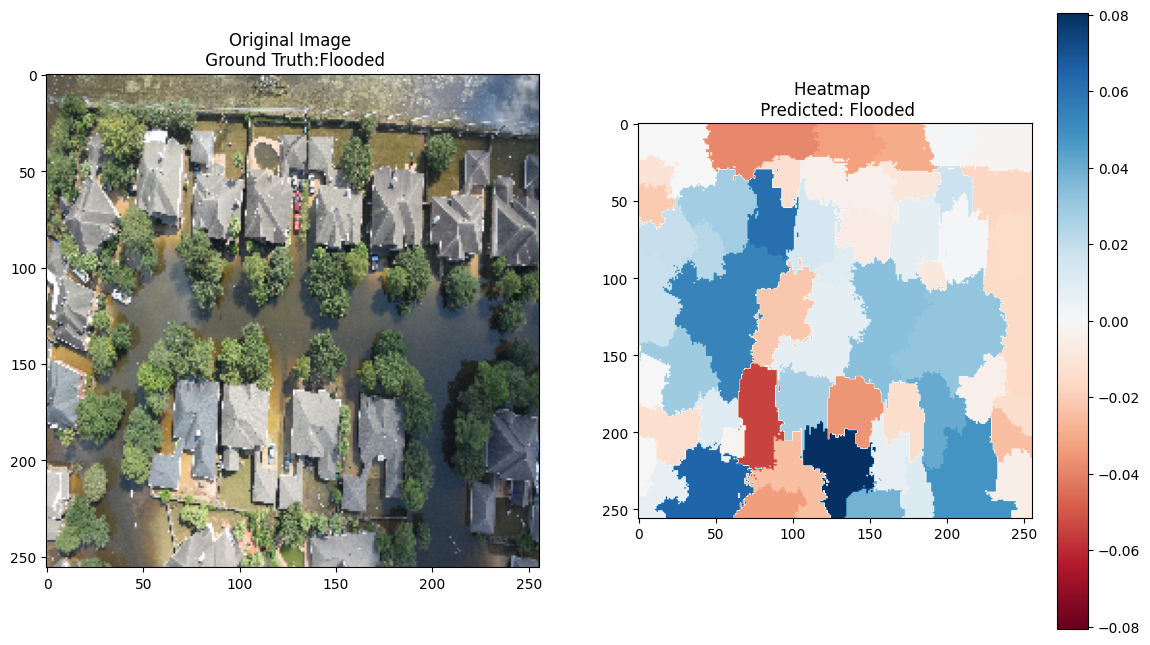

In [294]:
apply_lime(X_test_images[2], X_test_labels[2])

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step
Predicted: Flooded with 100.0% confidence


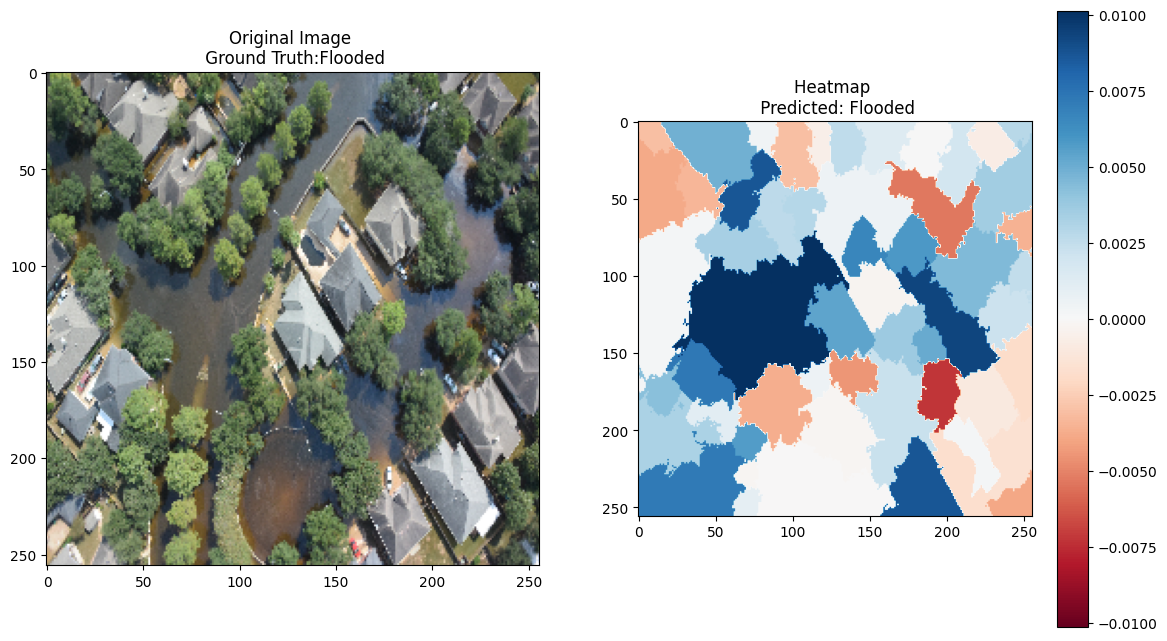

In [298]:
apply_lime(X_test_images[15], X_test_labels[15])

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step
Predicted: Flooded with 99.9% confidence


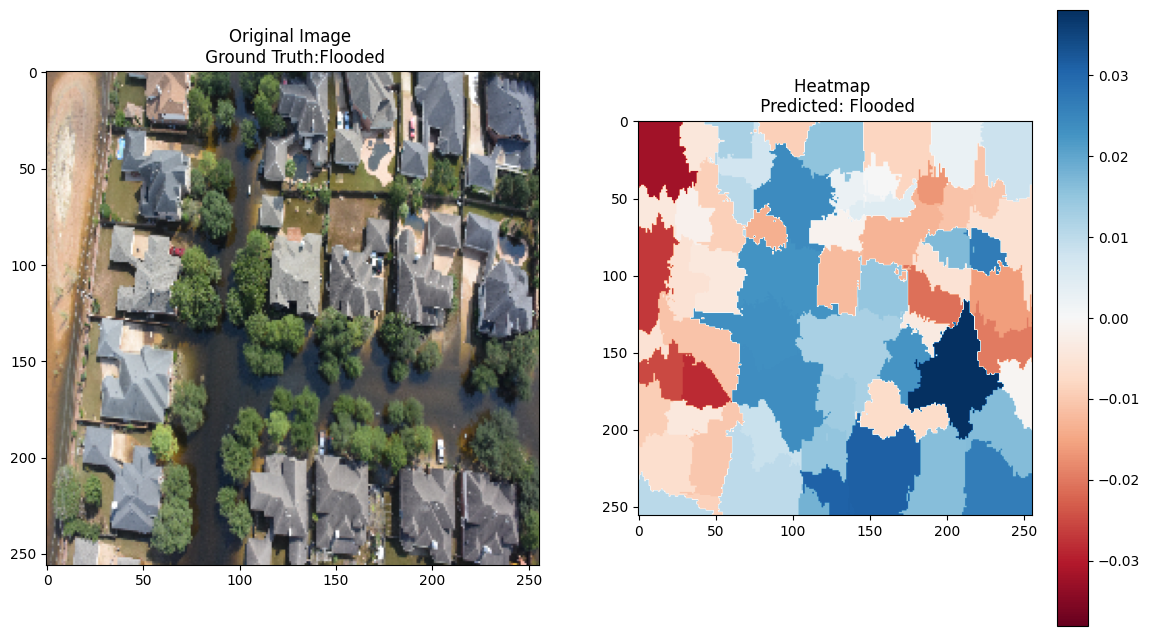

In [301]:
apply_lime(X_test_images[22], X_test_labels[22])

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step
Predicted: Non-Flooded with 99.94% confidence


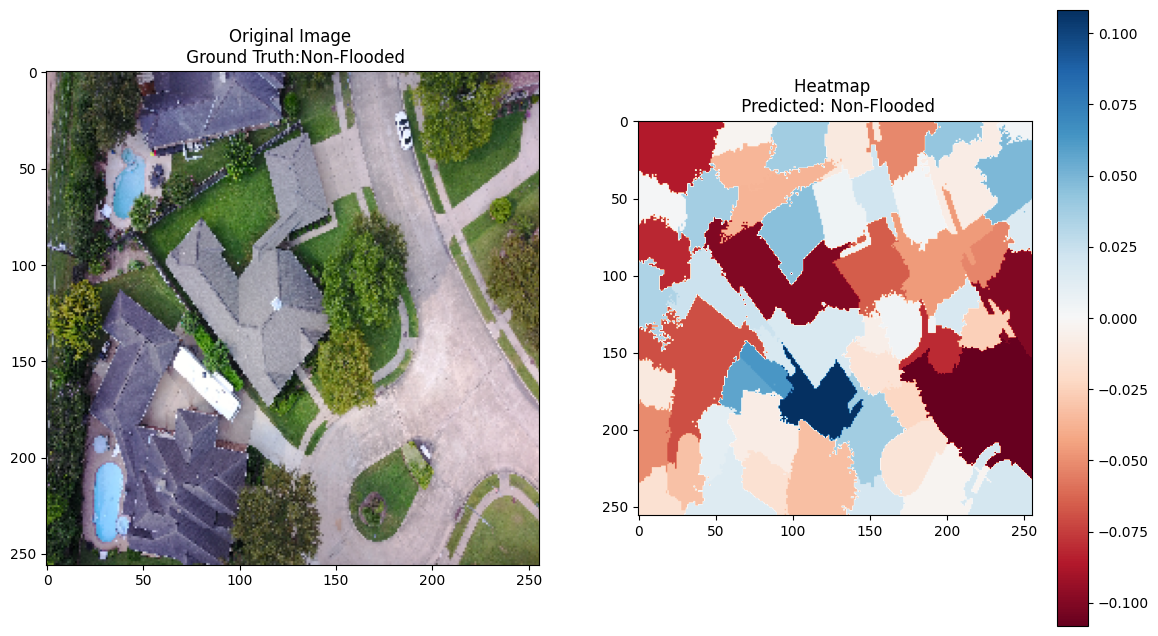

In [302]:
apply_lime(X_test_images[10], X_test_labels[10])

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step
Predicted: Non-Flooded with 100.0% confidence


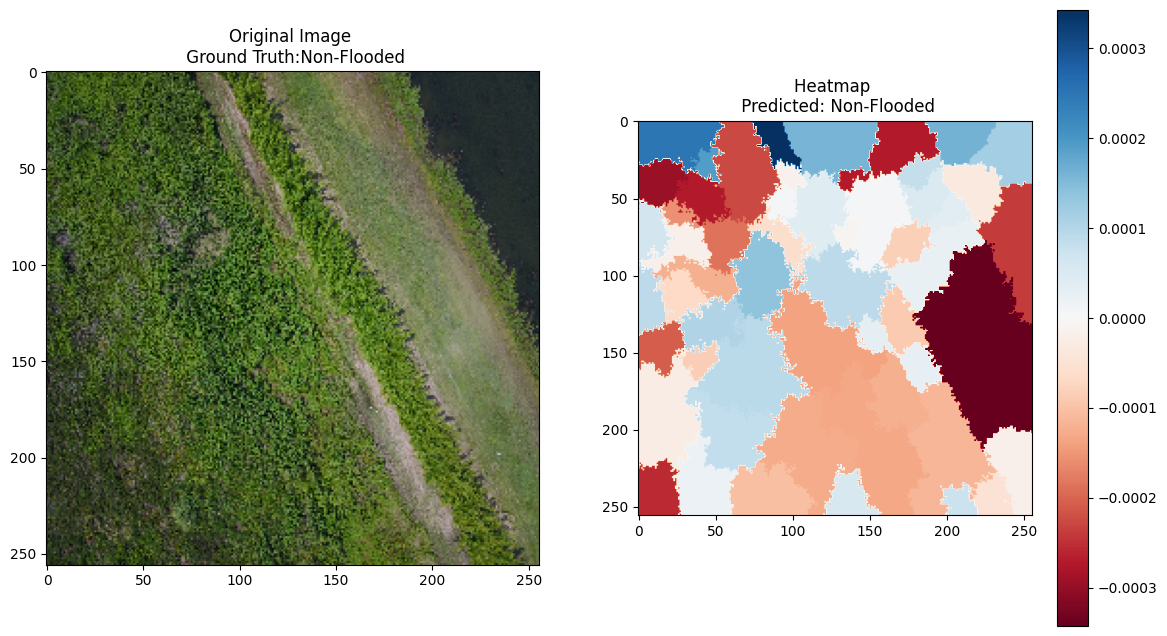

In [307]:
apply_lime(X_test_images[26], X_test_labels[26])